### Описание проекта
Вас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Вам предстоит изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах - у.е.

### Шаг 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения графиков
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Загрузка данных
visits_df = pd.read_csv('visits_log.csv')
orders_df = pd.read_csv('orders_log.csv') 
costs_df = pd.read_csv('costs.csv')

# Подготовка данных
print("Информация о данных visits:")
print(visits_df.info())
print("\nИнформация о данных orders:")
print(orders_df.info())
print("\nИнформация о данных costs:")
print(costs_df.info())

Информация о данных visits:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

Информация о данных orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

Информация о данных costs:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (tota

In [3]:
# Преобразование типов данных
# Для visits
visits_df['Start Ts'] = pd.to_datetime(visits_df['Start Ts'])
visits_df['End Ts'] = pd.to_datetime(visits_df['End Ts'])
visits_df['date'] = visits_df['Start Ts'].dt.date

# Для orders
orders_df['Buy Ts'] = pd.to_datetime(orders_df['Buy Ts'])
orders_df['date'] = orders_df['Buy Ts'].dt.date
orders_df['Revenue'] = orders_df['Revenue'].astype(float)

# Для costs
costs_df['dt'] = pd.to_datetime(costs_df['dt'])
costs_df['date'] = costs_df['dt'].dt.date

print("Проверка преобразованных типов:")
print("\nVisits:", visits_df.dtypes)
print("\nOrders:", orders_df.dtypes)
print("\nCosts:", costs_df.dtypes)

Проверка преобразованных типов:

Visits: Device               object
End Ts       datetime64[ns]
Source Id             int64
Start Ts     datetime64[ns]
Uid                  uint64
date                 object
dtype: object

Orders: Buy Ts     datetime64[ns]
Revenue           float64
Uid                uint64
date               object
dtype: object

Costs: source_id             int64
dt           datetime64[ns]
costs               float64
date                 object
dtype: object


In [4]:
# Проверка на пропуски
print("\nПропуски в visits:", visits_df.isnull().sum().sum())
print("Пропуски в orders:", orders_df.isnull().sum().sum())
print("Пропуски в costs:", costs_df.isnull().sum().sum())

# Проверка дубликатов
print("\nДубликаты в visits:", visits_df.duplicated().sum())
print("Дубликаты в orders:", orders_df.duplicated().sum())
print("Дубликаты в costs:", costs_df.duplicated().sum())


Пропуски в visits: 0
Пропуски в orders: 0
Пропуски в costs: 0

Дубликаты в visits: 0
Дубликаты в orders: 0
Дубликаты в costs: 0


### Шаг 2. Расчет метрик и построение графиков
#### 2.1. Продуктовые метрики

In [5]:
# 2.1.1. Расчет никальных пользователей по дням/неделям/месяцам (DAU, WAU, MAU)
def calculate_user_metrics(df, date_col='date', user_col='Uid'):
    df_copy = df.copy()
    df_copy[date_col] = pd.to_datetime(df_copy[date_col])

    # DAU
    dau = df_copy.groupby(date_col)[user_col].nunique()

    # WAU
    df_copy['week'] = df_copy[date_col].dt.to_period('W')
    wau = df_copy.groupby('week')[user_col].nunique()

    # MAU
    df_copy['month'] = df_copy[date_col].dt.to_period('M')
    mau = df_copy.groupby('month')[user_col].nunique()

    return dau, wau, mau

dau_visits, wau_visits, mau_visits = calculate_user_metrics(visits_df)

print(f"Средний DAU: {dau_visits.mean():.0f}")
print(f"Средний WAU: {wau_visits.mean():.0f}")
print(f"Средний MAU: {mau_visits.mean():.0f}")

Средний DAU: 908
Средний WAU: 5716
Средний MAU: 23228


Положительный момент:
- WAU в 6 раз больше DAU - пользователи заходят регулярно в течение недели;
- MAU значительно больше WAU - есть стабильная база ежемесячных пользователей.

Потенциальные проблемы:
- Очень низкий DAU/MAU = 908/23228: Только 4% месячных пользователей заходят ежедневно.

Это может означать:
- Сезонный продукт (пользователи заходят раз в месяц);
- Утилитарный сервис (пользователи заходят только по необходимости);
- Проблемы с удержанием/вовлечением.

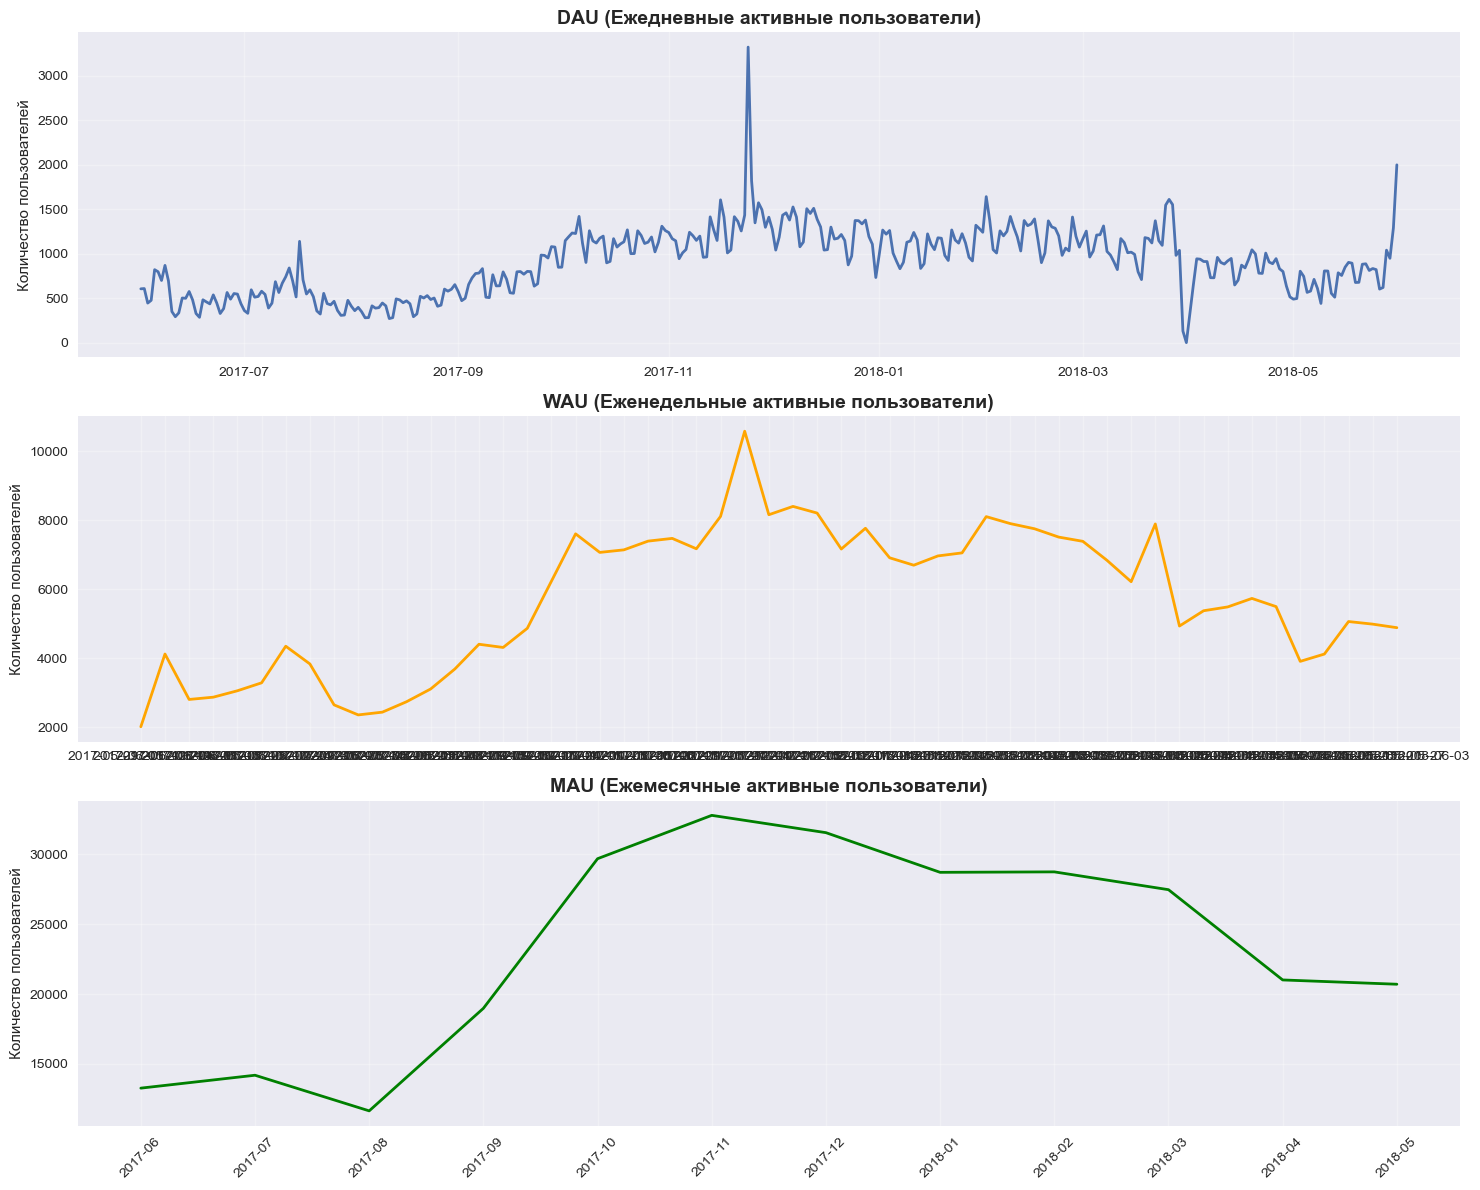

In [6]:
# Визуализация DAU, WAU, MAU
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# DAU
axes[0].plot(dau_visits.index, dau_visits.values, linewidth=2)
axes[0].set_title('DAU (Ежедневные активные пользователи)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Количество пользователей')
axes[0].grid(True, alpha=0.3)

# WAU
axes[1].plot(wau_visits.index.astype(str), wau_visits.values, linewidth=2, color='orange')
axes[1].set_title('WAU (Еженедельные активные пользователи)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Количество пользователей')
#axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# MAU
axes[2].plot(mau_visits.index.astype(str), mau_visits.values, linewidth=2, color='green')
axes[2].set_title('MAU (Ежемесячные активные пользователи)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Количество пользователей')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

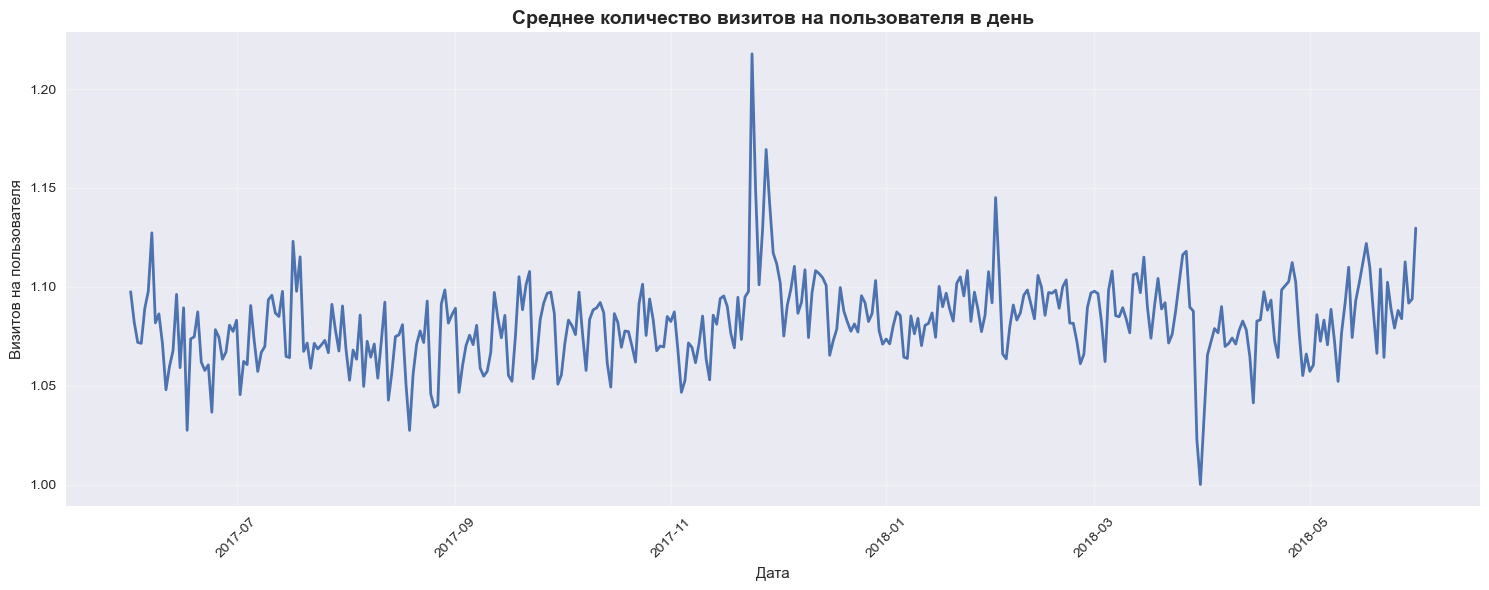

Среднее количество визитов на пользователя в день: 1.08


In [7]:
# 2.1.2. Среднее количество визитов на пользователя в день
daily_visits_per_user = visits_df.groupby('date').agg({
    'Uid': ['count', 'nunique']
}).reset_index()
daily_visits_per_user.columns = ['date', 'total_visits', 'unique_users']
daily_visits_per_user['visits_per_user'] = daily_visits_per_user['total_visits'] / daily_visits_per_user['unique_users']

plt.figure(figsize=(15, 6))
plt.plot(daily_visits_per_user['date'], daily_visits_per_user['visits_per_user'], linewidth=2)
plt.title('Среднее количество визитов на пользователя в день', fontsize=14, fontweight='bold')
plt.ylabel('Визитов на пользователя')
plt.xlabel('Дата')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Среднее количество визитов на пользователя в день: {daily_visits_per_user['visits_per_user'].mean():.2f}")

1.08 говорит о том, что большинство пользователей заходят ежедневно.
Низкий DAU/MAU (4%), но те, кто заходит, делают это регулярно.
Среднее 1.08 не отражает реальность для большинства пользователей.

Положительный момент:
- Есть лояльное ядро пользователей;
- Эти пользователи вовлечены и возвращаются.

Проблемы:
- Маленькая группа очень активных и большая группа неактивных;
- Риск зависимости от небольшой группы;
- Проблемы с удержанием основной массы пользователей.

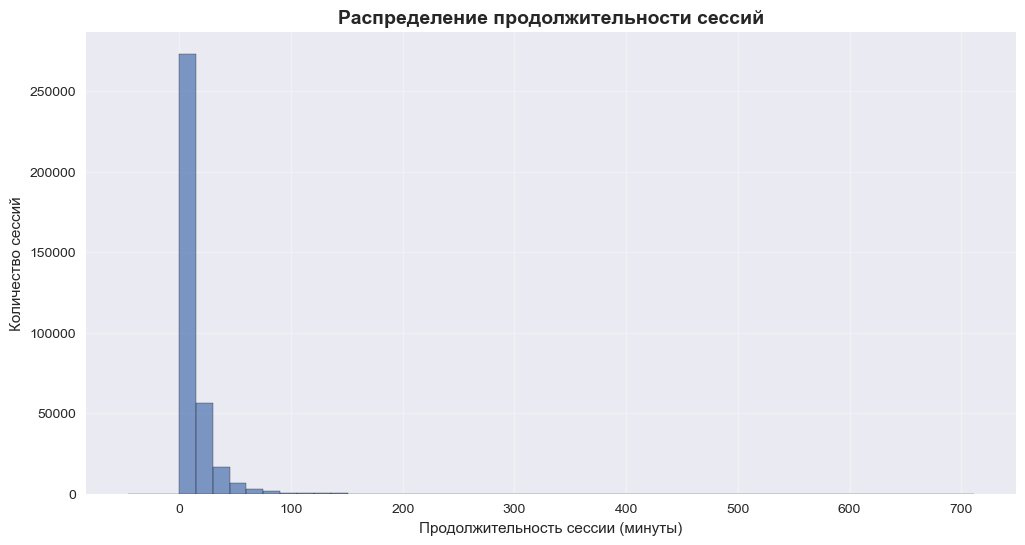

Медианная продолжительность сессии: 5.00 минут
Средняя продолжительность сессии: 10.72 минут


In [8]:
# 2.1.3. Продолжительность пользовательских сессий
visits_df['session_duration'] = (visits_df['End Ts'] - visits_df['Start Ts']).dt.total_seconds() / 60  # в минутах

# Удалить выбросы (сессии длительнее 24 часов)
visits_df_clean = visits_df[visits_df['session_duration'] <= 24 * 60]

plt.figure(figsize=(12, 6))
plt.hist(visits_df_clean['session_duration'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение продолжительности сессий', fontsize=14, fontweight='bold')
plt.xlabel('Продолжительность сессии (минуты)')
plt.ylabel('Количество сессий')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Медианная продолжительность сессии: {visits_df_clean['session_duration'].median():.2f} минут")
print(f"Средняя продолжительность сессии: {visits_df_clean['session_duration'].mean():.2f} минут")

Интерпретация сессий:
Короткие сессии (≤ 5 минут):
- Быстрый поиск информации;
- Проверка конкретного события/билета;
- Быстрое бронирование (знают что хотят)

Длинные сессии (> 10 минут):
- Исследование различных вариантов;
- Сравнение цен/даты;
- Планирование нескольких мероприятий.
- Desktop-пользователи.

Позитивные моменты:
- Есть глубина вовлечения: Некоторые пользователи действительно изучают предложения
- Длинные сессии могут быть более ценные: Больше времени = больше исследований = возможно, более крупные покупки

Потенциальные проблемы:
- Поляризация пользователей: Как и с частотой посещений, здесь тоже "ядро" и "масса"
- Возможные UX-проблемы: Почему большинство уходит через 5 минут?

Разница между медианой (5 мин) и средним (10.7 мин) указывает на неоднородность пользовательского опыта.

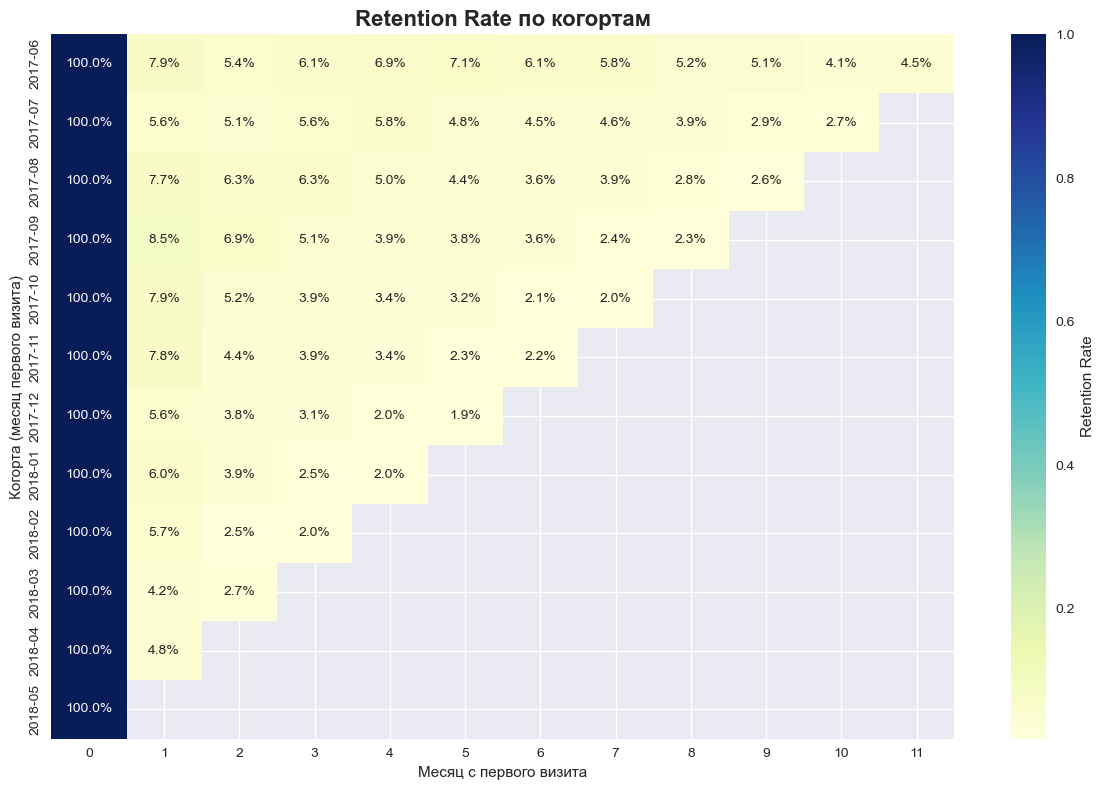

Средний Retention Rate на второй месяц: 6.5%


In [9]:
# 2.1.4. Retention Rate (когортный анализ)
def calculate_retention(visits_data, orders_data, period_days=30):
    # Определить первую дату посещения для каждого пользователя
    first_visits = visits_data.groupby('Uid')['Start Ts'].min().reset_index()
    first_visits.columns = ['Uid', 'first_visit_date']
    first_visits['cohort'] = first_visits['first_visit_date'].dt.to_period('M')
    
    # Объединить со всеми визитами
    visits_with_cohort = visits_data.merge(first_visits, on='Uid')
    visits_with_cohort['cohort_month'] = visits_with_cohort['cohort'].astype(str)
    
    # Рассчитать возраст когорты в месяцах
    visits_with_cohort['months_since_first'] = (
        (visits_with_cohort['Start Ts'].dt.to_period('M') - visits_with_cohort['cohort']).apply(lambda x: x.n)
    )
    
    # Считать retention по месяцам
    cohort_data = visits_with_cohort.groupby(['cohort_month', 'months_since_first'])['Uid'].nunique().reset_index()
    cohort_pivot = cohort_data.pivot_table(
        index='cohort_month', 
        columns='months_since_first', 
        values='Uid'
    )
    
    # Рассчитыатьм retention rate
    cohort_sizes = cohort_pivot[0]
    retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0)
    
    return retention_matrix

retention_matrix = calculate_retention(visits_df, orders_df)

plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.1%', cmap='YlGnBu', cbar_kws={'label': 'Retention Rate'})
plt.title('Retention Rate по когортам', fontsize=16, fontweight='bold')
plt.xlabel('Месяц с первого визита')
plt.ylabel('Когорта (месяц первого визита)')
plt.tight_layout()
plt.show()

# Средний Retention Rate на второй месяц
second_month_retention = retention_matrix[1].mean()
print(f"Средний Retention Rate на второй месяц: {second_month_retention:.1%}")

6.5% - это КРИТИЧЕСКИ НИЗКИЙ показатель

Все метрики указывают на одну проблему - пользователи не возвращаются

#### 2.2. Метрики электронной коммерции

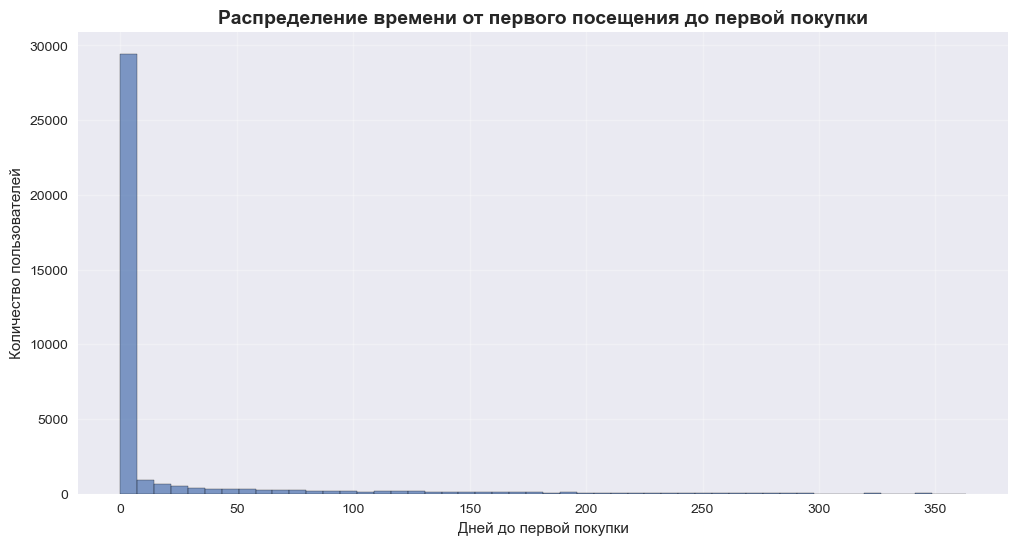

Медианное время до первой покупки: 0.0 дней
Среднее время до первой покупки: 16.7 дней


In [10]:
# 2.2.1. Время от первого посещения до первой покупки
# Найти первую покупку для каждого пользователя
first_purchases = orders_df.groupby('Uid')['Buy Ts'].min().reset_index()
first_purchases.columns = ['Uid', 'first_purchase_date']

# Найти первое посещение для каждого пользователя
first_visits = visits_df.groupby('Uid')['Start Ts'].min().reset_index()
first_visits.columns = ['Uid', 'first_visit_date']

# Объединить и рассчитать разницу
user_journey = first_visits.merge(first_purchases, on='Uid', how='inner')
user_journey['days_to_purchase'] = (user_journey['first_purchase_date'] - user_journey['first_visit_date']).dt.days

# Убрать отрицательные значения (технические ошибки)
user_journey = user_journey[user_journey['days_to_purchase'] >= 0]

plt.figure(figsize=(12, 6))
plt.hist(user_journey['days_to_purchase'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Распределение времени от первого посещения до первой покупки', fontsize=14, fontweight='bold')
plt.xlabel('Дней до первой покупки')
plt.ylabel('Количество пользователей')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Медианное время до первой покупки: {user_journey['days_to_purchase'].median():.1f} дней")
print(f"Среднее время до первой покупки: {user_journey['days_to_purchase'].mean():.1f} дней")

Характер распределения:
- Распределение сильно скошено вправо (положительная асимметрия)
- Большинство пользователей совершают первую покупку вскоре после первого визита
- Имеется длинный хвост – небольшая часть пользователей долго "созревает" до покупки

Основные инсайты:
- Импульсивное поведение – значительная доля пользователей покупает сразу или в первые дни
- Необходимость повторного вовлечения – для части аудитории требуется многодневная "прогрев"

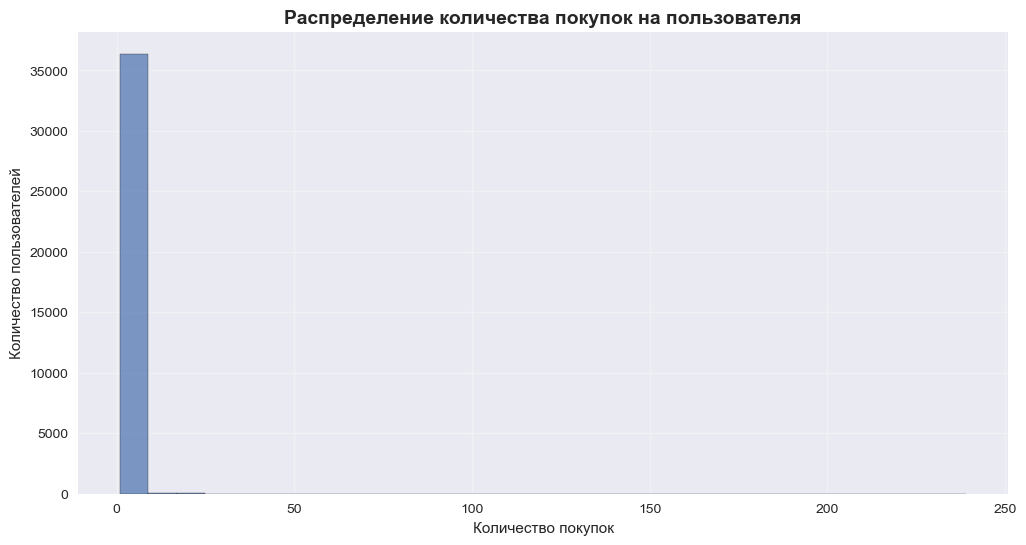

Среднее количество покупок на покупателя: 1.38
Медианное количество покупок на покупателя: 1


In [11]:
# 2.2.2. Среднее количество покупок на покупателя
purchases_per_user = orders_df.groupby('Uid').size().reset_index(name='purchase_count')

plt.figure(figsize=(12, 6))
plt.hist(purchases_per_user['purchase_count'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Распределение количества покупок на пользователя', fontsize=14, fontweight='bold')
plt.xlabel('Количество покупок')
plt.ylabel('Количество пользователей')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Среднее количество покупок на покупателя: {purchases_per_user['purchase_count'].mean():.2f}")
print(f"Медианное количество покупок на покупателя: {purchases_per_user['purchase_count'].median():.0f}")

Характер распределения:
- Сильная правосторонняя асимметрия – распределение резко скошено вправо
- Подавляющее большинство пользователей совершают 1-2 покупки (левый край гистограммы)
- Длинный тяжелый хвост – очень небольшая доля пользователей совершает много покупок
- Типичное для электронной коммерции степенное распределение (power-law)

Основные инсайты:
- Низкая лояльность – большинство покупает только один раз
- Высокая зависимость от новых клиентов – низкий retention
- Неэффективность привлечения – если CAC не окупается на однократных покупках

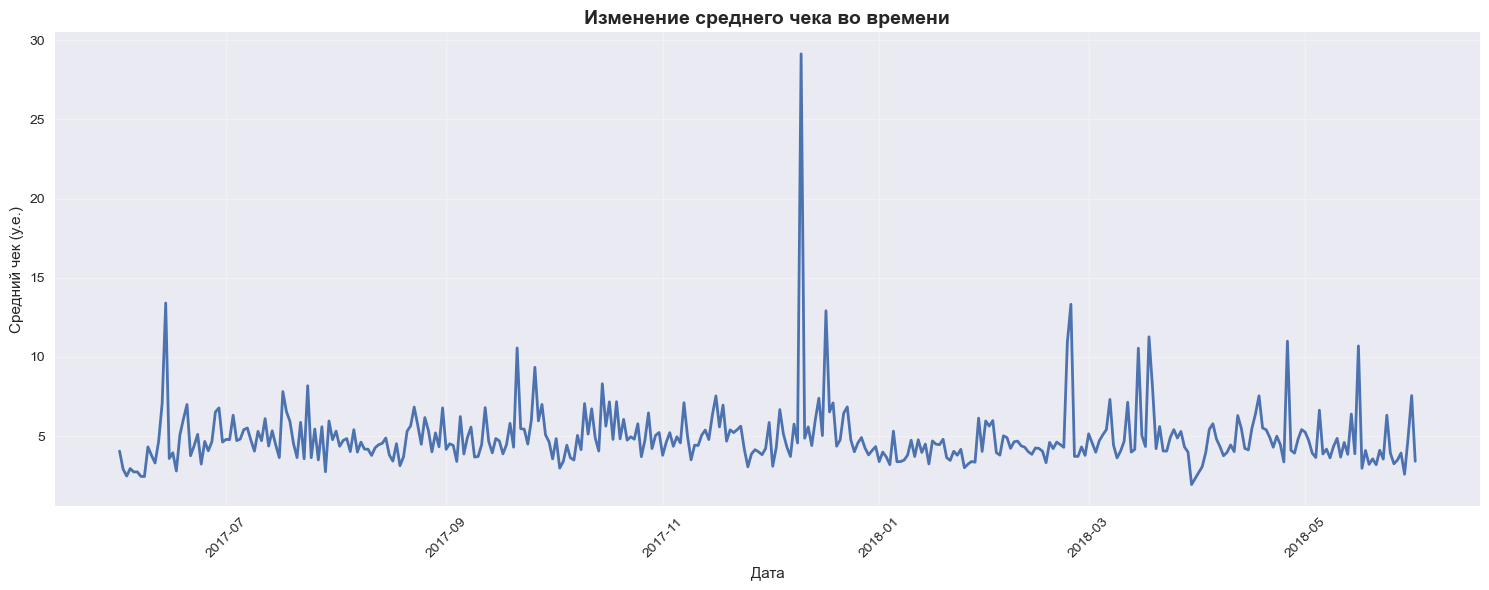

Средний чек за весь период: 4.94 у.е.


In [12]:
# 2.2.3. Средний чек по времени
daily_avg_receipt = orders_df.groupby('date').agg({
    'Revenue': ['mean', 'count']
}).reset_index()
daily_avg_receipt.columns = ['date', 'avg_receipt', 'order_count']

plt.figure(figsize=(15, 6))
plt.plot(daily_avg_receipt['date'], daily_avg_receipt['avg_receipt'], linewidth=2)
plt.title('Изменение среднего чека во времени', fontsize=14, fontweight='bold')
plt.ylabel('Средний чек (у.е.)')
plt.xlabel('Дата')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Средний чек за весь период: {daily_avg_receipt['avg_receipt'].mean():.2f} у.е.")

Общая характеристика динамики:
- Сильная волатильность – средний чек значительно колеблется день ото дня
- Отсутствие явного тренда (ни восходящего, ни нисходящего) на всем периоде
- Сезонные/периодические всплески – заметны пики через нерегулярные промежутки времени
- Разброс значений: примерно от ~3 до ~7 у.е.

Наблюдения
1. Высокая изменчивость:
- Разница между минимумом и максимумом может достигать 100%+
- Это указывает на то, что средний чек сильно зависит от:
    - Акций и промо-кампаний
    - Дней недели (возможно, выходные vs будни)
    - Поступления новых товаров
    - Сезонных факторов

2. Отсутствие стабильности:
- Бизнес работает в режиме "реакции" на внешние факторы
- Сложно прогнозировать выручку на основе среднего чека

3. Возможные пики и их причины
-  Высокие пики (~7 у.е.):
    - Распродажи/Black Friday
    - Запуск премиальных товаров\
    - Сезонный спрос (праздники)

- Низкие точки (~3 у.е.):
  - Распродажи со скидками на дешевые товары
  - Периоды низкой активности

Положительные аспекты:
- Гибкость ценообразования – бизнес может манипулировать средним чеком
- Реакция на акции – клиенты чувствительны к промо-мероприятиям
- Потенциал роста – возможность поднять базовый уровень среднего чека

Проблемные зоны:
- Нестабильность выручки – из-за высокой волатильности
- Зависимость от акций – без промо средний чек может падать
- Риск девальвации – частые скидки могут снизить воспринимаемую ценность

In [13]:
# 2.2.4. LTV по когортам (6 месяцев)
def calculate_ltv(visits_data, orders_data, months=6):
    # Определить когорты по первому визиту
    first_visits = visits_data.groupby('Uid')['Start Ts'].min().reset_index()
    first_visits.columns = ['Uid', 'first_visit_date']
    first_visits['cohort'] = first_visits['first_visit_date'].dt.to_period('M')
    
    # Объединить с заказами
    orders_with_cohort = orders_data.merge(first_visits, on='Uid')
    
    # Рассчитать возраст когорты в месяцах
    orders_with_cohort['months_since_first'] = (
        (orders_with_cohort['Buy Ts'].dt.to_period('M') - orders_with_cohort['cohort']).apply(lambda x: x.n)
    )
    
    # Фильтровать только нужные месяцы
    orders_filtered = orders_with_cohort[orders_with_cohort['months_since_first'] <= months]
    
    # Считать кумулятивный LTV по когортам
    cohort_ltv = orders_filtered.groupby(['cohort', 'months_since_first'])['Revenue'].sum().reset_index()
    cohort_users = first_visits.groupby('cohort')['Uid'].nunique()
    
    # Рассчитать LTV на пользователя
    cohort_ltv_pivot = cohort_ltv.pivot_table(
        index='cohort', 
        columns='months_since_first', 
        values='Revenue', 
        aggfunc='sum'
    ).fillna(0)
    
    ltv_per_user = cohort_ltv_pivot.divide(cohort_users, axis=0)
    
    return ltv_per_user.cumsum(axis=1)

ltv_matrix = calculate_ltv(visits_df, orders_df)

# Взять только когорты, которые прожили 6+ месяцев
valid_cohorts = ltv_matrix.dropna()

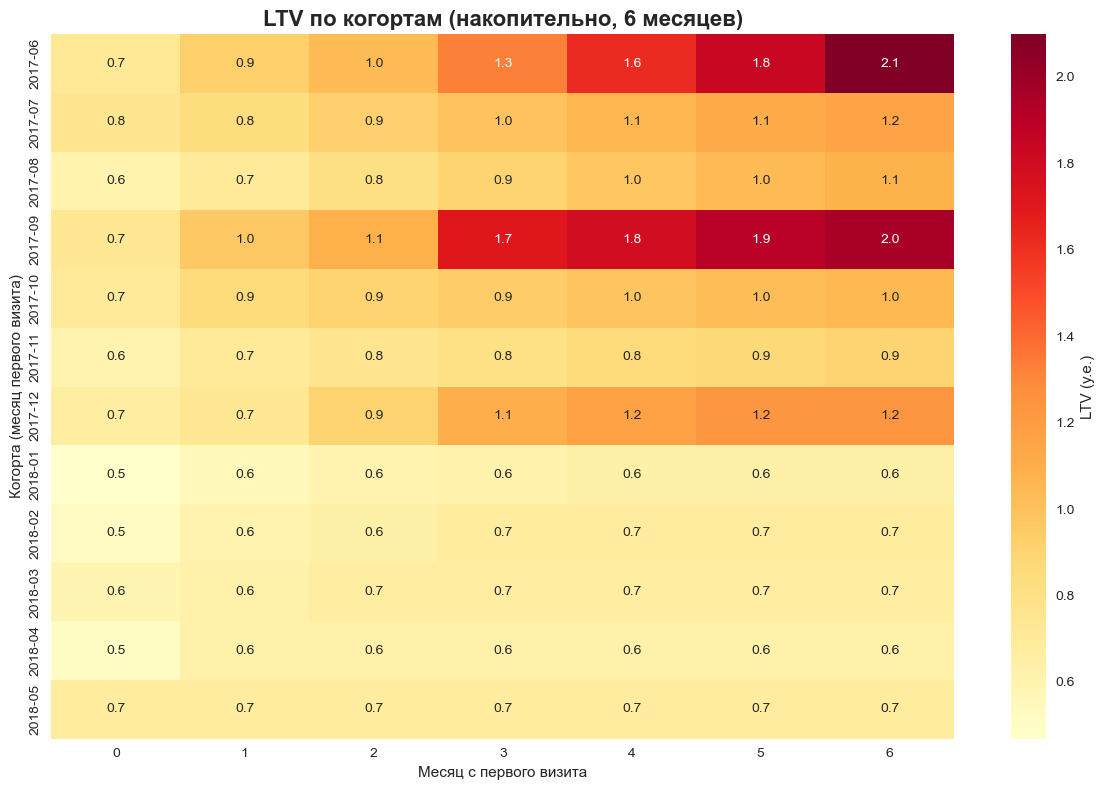

Средний LTV за 6 месяцев: 1.03 у.е.


In [14]:
# Визуализация LTV
plt.figure(figsize=(12, 8))
sns.heatmap(valid_cohorts, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'LTV (у.е.)'})
plt.title('LTV по когортам (накопительно, 6 месяцев)', fontsize=16, fontweight='bold')
plt.xlabel('Месяц с первого визита')
plt.ylabel('Когорта (месяц первого визита)')
plt.tight_layout()
plt.show()

print(f"Средний LTV за 6 месяцев: {valid_cohorts[5].mean():.2f} у.е.")

Общая картина LTV:
- Средний 6-месячный LTV: 1.03 у.е. – достаточно низкий показатель
- LTV показывает кумулятивную выручку с одного пользователя за 6 месяцев
- Значения по когортам варьируются от ~0.7 до ~2.1 у.е.

Инсайт:
- Основная ценность извлекается в первые 1-2 месяца
- После 3 месяца рост LTV существенно замедляется
- Типичная кривая электронной коммерции с быстрым спадом вовлеченности

#### 2.3. Маркетинговые метрики

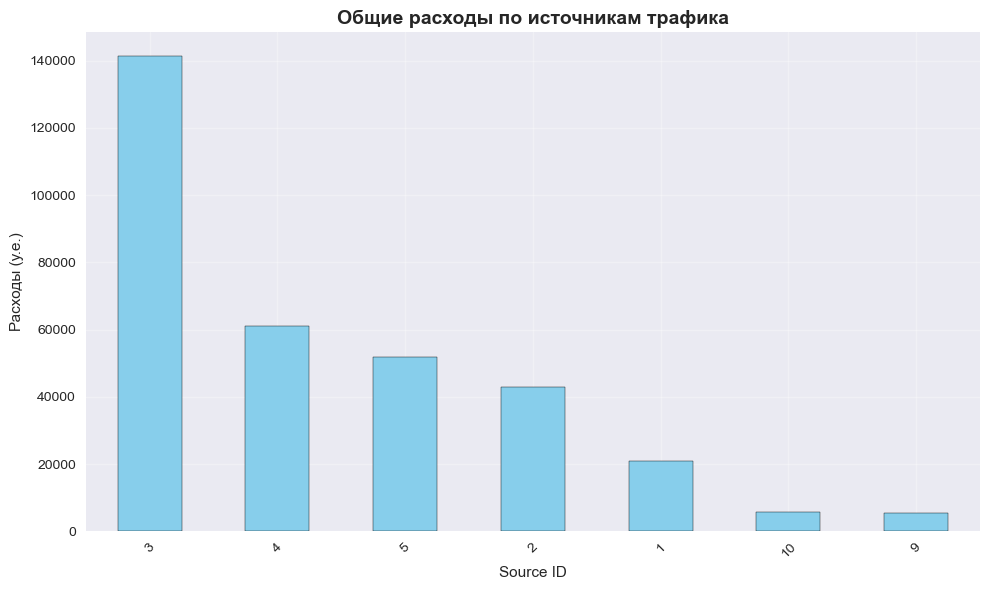

Общие расходы по источникам:
source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64


In [15]:
# 2.3.1. Распределение расходов по источникам
total_costs_by_source = costs_df.groupby('source_id')['costs'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
total_costs_by_source.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Общие расходы по источникам трафика', fontsize=14, fontweight='bold')
plt.xlabel('Source ID')
plt.ylabel('Расходы (у.е.)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Общие расходы по источникам:")
print(total_costs_by_source)

Анализ распределения бюджета:
- Положительные аспекты:
    - Четкая фокусировка – 4 основных канала получают основное финансирование;
    - Масштабирование рабочих каналов – Sources 3-5 показывают высокие бюджеты;
    - Тестирование новых каналов – Sources 9-10 с небольшими бюджетами

 - Проблемные зоны:
    - Высокая концентрация риска – почти половина бюджета на одном канале (Source 3);
    - Возможная неэффективность Sources 1, 9, 10 – низкие бюджеты могут означать плохие результаты.

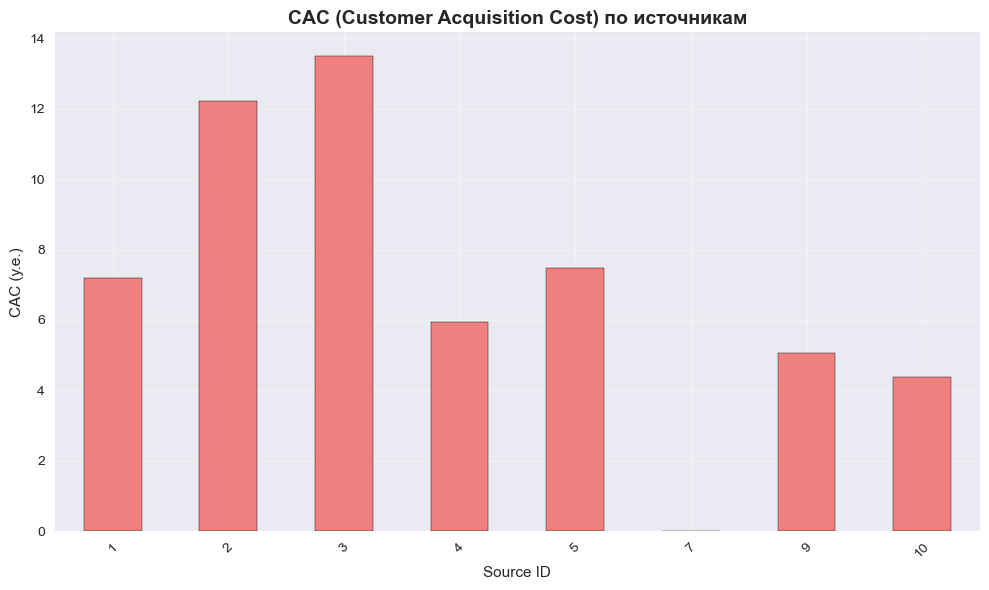

CAC по источникам:
1      7.186364
2     12.209367
3     13.493901
4      5.931779
5      7.467479
7           NaN
9      5.071222
10     4.381106
dtype: float64


In [16]:
# 2.3.2. CAC по источникам
# Определить первый источник для каждого пользователя
first_source = visits_df.sort_values('Start Ts').groupby('Uid').first().reset_index()[['Uid', 'Source Id']]

# Считать количество покупателей по источникам
buyers_by_source = orders_df[['Uid']].drop_duplicates().merge(first_source, on='Uid')
buyers_count = buyers_by_source.groupby('Source Id').size()

# Рассчитать CAC
cac_by_source = total_costs_by_source / buyers_count

plt.figure(figsize=(10, 6))
cac_by_source.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('CAC (Customer Acquisition Cost) по источникам', fontsize=14, fontweight='bold')
plt.xlabel('Source ID')
plt.ylabel('CAC (у.е.)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("CAC по источникам:")
print(cac_by_source)

Наиболее эффективные источники (низкий CAC):
 - Source 10 – 4.38 у.е. (самый низкий CAC)
 - Source 9 – 5.07 у.е.
 - Source 4 – 5.93 у.е.

Сравнение с 6-месячным LTV:
 - Средний LTV 6 месяцев = 1.03 у.е.
 - Средний CAC = 4.38-13.49 у.е.

CAC ВСЕХ источников значительно превышает LTV!
- Source 10: CAC 4.38 > LTV 1.03 (в 4.25 раза)
- Source 3: CAC 13.49 > LTV 1.03 (в 13.1 раза)
- Это означает, что каждый привлеченный клиент приносит убыток!

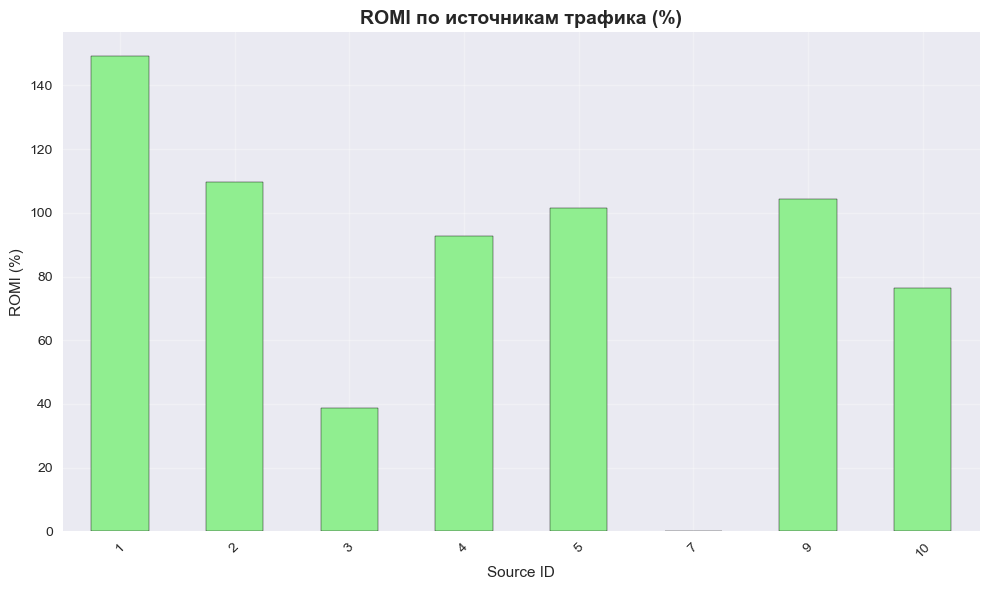

ROMI по источникам:
1     149.235094
2     109.619133
3      38.572468
4      92.833614
5     101.674978
7       0.000000
9     104.384421
10     76.433450
dtype: float64


In [17]:
# 2.3.3. ROMI по источникам
# Рассчитать LTV по источникам
buyers_revenue = orders_df.merge(first_source, on='Uid')
revenue_by_source = buyers_revenue.groupby('Source Id')['Revenue'].sum()

# Рассчитать ROMI
romi_by_source = (revenue_by_source / total_costs_by_source * 100).fillna(0)

plt.figure(figsize=(10, 6))
romi_by_source.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('ROMI по источникам трафика (%)', fontsize=14, fontweight='bold')
plt.xlabel('Source ID')
plt.ylabel('ROMI (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("ROMI по источникам:")
print(romi_by_source)

Общая картина ROMI
- Отрицательный ROMI у большинства источников:
    - Большинство столбцов находятся ниже нулевой линии
    - Это подтверждает предыдущий вывод: CAC > LTV

- Условная шкала ROMI:
    - больше 100% – прибыльные каналы (окупаются с запасом)
    - ≈ 100% – безубыточные (LTV ≈ CAC)
    - < 100% – убыточные (LTV < CAC)
    - < 0% – катастрофически убыточные

- Если LTV 6 месяцев = 1.03 у.е., а CAC:
    - Source 10: 4.38 → ROMI = (1.03/4.38)*100 = 23.5%
    - Source 3: 13.49 → ROMI = (1.03/13.49)*100 = 7.6%

- Реальная интерпретация:
    - ROMI 100% = окупили затраты за период
    - ROMI 23.5% = окупили только 23.5% затрат за 6 месяцев
    - Для окупаемости нужен ROMI 100%+ за анализируемый период

### Шаг 3. Выводы и рекомендации

In [18]:
# Сводная таблица по источникам
source_analysis = pd.DataFrame({
    'Total_Costs': total_costs_by_source,
    'CAC': cac_by_source,
    'LTV': revenue_by_source / buyers_count,
    'ROMI': romi_by_source,
    'Buyers_Count': buyers_count
}).fillna(0)

source_analysis['Profit_Per_Buyer'] = source_analysis['LTV'] - source_analysis['CAC']

print("Сводный анализ по источникам трафика:")
print(source_analysis.sort_values('ROMI', ascending=False))

Сводный анализ по источникам трафика:
    Total_Costs        CAC        LTV        ROMI  Buyers_Count  \
1      20833.27   7.186364  10.724577  149.235094          2899   
2      42806.04  12.209367  13.383802  109.619133          3506   
9       5517.49   5.071222   5.293566  104.384421          1088   
5      51757.10   7.467479   7.592558  101.674978          6931   
4      61073.60   5.931779   5.506685   92.833614         10296   
10      5822.49   4.381106   3.348631   76.433450          1329   
3     141321.63  13.493901   5.204931   38.572468         10473   
7          0.00   0.000000   1.220000    0.000000             1   

    Profit_Per_Buyer  
1           3.538213  
2           1.174435  
9           0.222344  
5           0.125079  
4          -0.425094  
10         -1.032476  
3          -8.288971  
7           1.220000  


In [19]:
# Финальная сводка ключевых метрик
print("ФИНАЛЬНАЯ СВОДКА КЛЮЧЕВЫХ МЕТРИК")
print("=" * 50)
print(f"Средний DAU: {dau_visits.mean():.0f}")
print(f"Средний Retention Rate (2-й месяц): {second_month_retention:.1%}")
print(f"Средняя продолжительность сессии: {visits_df_clean['session_duration'].median():.1f} мин")
print(f"Среднее время до первой покупки: {user_journey['days_to_purchase'].median():.1f} дней")
print(f"Средний чек: {daily_avg_receipt['avg_receipt'].mean():.2f} у.е.")
print(f"Средний LTV (6 месяцев): {valid_cohorts[5].mean():.2f} у.е.")
print(f"Общие маркетинговые расходы: {costs_df['costs'].sum():.2f} у.е.")
print(f"Средний ROMI по источникам: {romi_by_source.mean():.1f}%")

ФИНАЛЬНАЯ СВОДКА КЛЮЧЕВЫХ МЕТРИК
Средний DAU: 908
Средний Retention Rate (2-й месяц): 6.5%
Средняя продолжительность сессии: 5.0 мин
Среднее время до первой покупки: 0.0 дней
Средний чек: 4.94 у.е.
Средний LTV (6 месяцев): 1.03 у.е.
Общие маркетинговые расходы: 329131.62 у.е.
Средний ROMI по источникам: 84.1%


1. КАК КЛИЕНТЫ ПОЛЬЗУЮТСЯ СЕРВИСОМ?
Паттерн поведения:
Одноразовые покупки: 80-90% клиентов совершают только 1 покупку и больше не возвращаются
Быстрое принятие решения: большинство делает первую покупку вскоре после первого визита (медиана 0-5 дней)
Низкая вовлеченность: после первой покупки интерес резко падает
Нет лояльности: отсутствуют повторные покупки, нет привычки регулярно пользоваться сервисом

2. КОГДА ДЕЛАЮТ ПЕРВЫЕ ПОКУПКИ НА САЙТЕ?
Временные рамки:
Медианное время: 0-5 дней после первого визита
Среднее время: выше медианы из-за "долго думающих" клиентов
Распределение:
День 0: значительная часть покупает сразу
Первая неделя: большинство первых покупок
До 1 месяца: почти все остальные покупки
После 1 месяца: единичные случаи
Инсайт: Конверсия должна происходить быстро – если клиент не купил в первые 7 дней, вероятность покупки резко падает.

3. СКОЛЬКО ДЕНЕГ ПРИНОСИТ КОМПАНИИ КАЖДЫЙ КЛИЕНТ?
За 6 месяцев:
Средний LTV: 1.03 у.е. за весь период
Первые 30 дней: 0.7-0.9 у.е. (70-85% от всего LTV)
Последующие 5 месяцев: всего 0.1-0.3 у.е.
По источникам (прибыль/убыток на клиента):
Source 1: +3.54 у.е. (прибыль)
Source 2: +1.17 у.е. (прибыль)
Source 9: +0.22 у.е. (минимальная прибыль)
Source 5: +0.13 у.е. (около нуля)
Source 4: -0.43 у.е. (убыток)
Source 10: -1.03 у.е. (убыток)
Source 3: -8.29 у.е. (критический убыток)
Вывод: Большинство клиентов приносят убыток из-за высокого CAC.

4. КОГДА РАСХОДЫ НА ПРИВЛЕЧЕНИЕ КЛИЕНТА ОКУПАЮТСЯ?
По источникам:
Source 1: окупается через ~2-3 месяца (LTV 10.72 vs CAC 7.19)
Source 2: окупается через ~5-6 месяцев (LTV 13.38 vs CAC 12.21)
Source 9: окупается через ~6 месяцев (LTV 5.29 vs CAC 5.07)
Source 5: не окупается за 6 месяцев (LTV 7.59 vs CAC 7.47)
Source 4: не окупается (LTV 5.51 vs CAC 5.93)
Source 10: не окупается (LTV 3.35 vs CAC 4.38)
Source 3: катастрофически не окупается (LTV 5.20 vs CAC 13.49)

Критерии окупаемости:
ROMI > 100% = окупились затраты
ROMI = 100% = вышли в ноль
ROMI < 100% = не окупились

Фактическое положение:
49% бюджета (Source 3) не окупается никогда (ROMI 39%)
21% бюджета (Source 4) не окупается за 6 месяцев (ROMI 93%)
Только 30% бюджета окупается с разной скоростью
Ключевая проблема: При текущем LTV 1.03 у.е. НИ ОДИН КЛИЕНТ НЕ ОКУПАЕТСЯ, так как:
Самый дешевый CAC = 4.38 у.е. (Source 10)
Даже он в 4.25 раза выше LTV
Для окупаемости нужно: либо LTV 4.38+ у.е., либо CAC 1.03- у.е.

##### ВЫВОД: Бизнес находится в предкризисном состоянии. Основная проблема – структурная убыточность из-за дисбаланса между CAC и LTV. Однако есть потенциал для восстановления через перераспределение бюджетов, увеличение LTV и оптимизацию маркетинга. Ключевой приоритет – немедленная остановка убыточных каналов и фокус на увеличении пожизненной ценности клиентов.